In [1]:
# test dataset img 저장
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets.coco import load_coco_json
from matplotlib import pyplot as plt
import os
import cv2
import random

# model load
model_name = 'faster_rcnn_R_101_C4_3x'
cfg = get_cfg()
cfg.OUTPUT_DIR = './logs/' + model_name
cfg.merge_from_file(cfg.OUTPUT_DIR + '/config.yaml')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0089999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# 학습된 전체 Category 개수
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
predictor = DefaultPredictor(cfg)

# img load
root_dir = "/detectron2_repo/datasets/data_voucher_2019"
group_dir = join(root_dir, "group1")
json_file = join(root_dir, group_dir, "annotations_json/instances_val.json")
image_root = join(root_dir, group_dir, "test_images")
img_list = [join(image_root, f) for f in sorted(listdir(image_root))]

In [2]:
# static method에 Category 정보 업데이트
from detectron2.category_info.category import Category

# 학습된 전체 Category 개수의 {"이름":번호}
category_all = {
    "Samdasoo_pet": 0,
    "CornsilkTea_pet": 1,
    "Cocacola_can": 2,
    "Pepsi_can": 3,
    "BananaMilk": 4,
    "Coolpeace_carton": 5,
    "LetsbeMild_can": 6,
    "MycafelatteMild": 7,
    "MinutemaidOrange_pet": 8,
    "BacchusF_glass": 9,
}

# Category list 초기화
# 전역 함수로 선언 -> 어느 곳에서나 접근 가능
Category.category_init(category_all)

cat_name_in = ["Samdasoo_pet", "CornsilkTea_pet", "Cocacola_can"]
Category.category_in(cat_name_in)
print(Category.cat_all_set)
print(Category.cat_in_set)
print(Category.cat_no_set)
print(Category.cat_all_dict)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2}
{3, 4, 5, 6, 7, 8, 9}
{'Samdasoo_pet': 0, 'CornsilkTea_pet': 1, 'Cocacola_can': 2, 'Pepsi_can': 3, 'BananaMilk': 4, 'Coolpeace_carton': 5, 'LetsbeMild_can': 6, 'MycafelatteMild': 7, 'MinutemaidOrange_pet': 8, 'BacchusF_glass': 9}


[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[1 1 1 1 2 2 0 0 0]
[[201, 476, 277, 575, 'CornsilkTea_pet', 0.5755145], [201, 476, 277, 575, 'CornsilkTea_pet', 0.5755145], [201, 476, 277, 575, 'CornsilkTea_pet', 0.5755145], [201, 476, 277, 575, 'CornsilkTea_pet', 0.5755145], [450, 260, 584, 339, 'Cocacola_can', 0.57530123], [450, 260, 584, 339, 'Cocacola_can', 0.57530123], [287, 415, 367, 530, 'Samdasoo_pet', 0.57563955], [287, 415, 367, 530, 'Samdasoo_pet', 0.57563955], [287, 415, 367, 530, 'Samdasoo_pet', 0.57563955]]


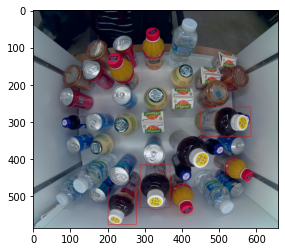

In [6]:
def make_proto(bbox, class_name, score):
    """
    Args를 취합하여 protobuf에 정의된 형식에 맞게 반환
    
    Args:
        bbox (1D-list): bbox 정보
        class_id (int): class id
        score (int): confidence score
    
    Return:
        1D-list: [xmin, ymin, xmax, ymax, class_info, score]
        xmin (int32): bbox의 min x 좌표
        ymin (int32): bbox의 min y 좌표
        xmax (int32): bbox의 max x 좌표
        ymax (int32): bbox의 max y 좌표
        class_info (str): 숫자로 표현된 class ->
                    Category에 정의된 dictionary를 이용해 string class로 바꿔줌
        score (float): confidence score
    """
    xmin = int(bbox[0])
    ymin = int(bbox[1])
    xmax = int(bbox[2])
    ymax = int(bbox[3])
   
    return [xmin, ymin, xmax, ymax, class_name, score]

def get_proto_info(output):
    """
    protobuf 통신을 위한 Detectron2 모델의 inference 결과를 반환하는 함수
    
    Arg:
        output (Boxes class): model이 예측한 결과물
    
    Return:
    
    """
    t_pred_classes = output['instances'].pred_classes
    classes = t_pred_classes.to("cpu").numpy()
    
    t_score = output['instances'].scores
    scores = t_score.to("cpu").numpy()

    t_boxes = output["instances"].pred_boxes
    bboxes = t_boxes.tensor.to("cpu").numpy()
    
    result = []
    for idx in classes:
        print(classes)
        b = bboxes[idx]
        c = Category.num_to_str(idx)
        s = scores[idx]
        res = make_proto(b, c, s)
        result.append(res)
    print(result)
    return result
        
        
for img_dir in random.sample(img_list, 1):    
    im = cv2.imread(img_dir)
    im = cv2.resize(im, (660, 585))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    output = predictor(im)
    res = get_proto_info(output)
    for iter, _ in enumerate(res):
        im = cv2.rectangle(im, (res[iter][0], res[iter][1]), (res[iter][2], res[iter][3]), color=(255, 0, 0))
    
    plt.imshow(im) 